In [11]:
import numpy as np
import torch
import torch.nn as nn
import random
import os

from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange
from infras.misc import *


# device = torch.device('cpu')
device = torch.device('cpu')


shape of data = (10000, 2)


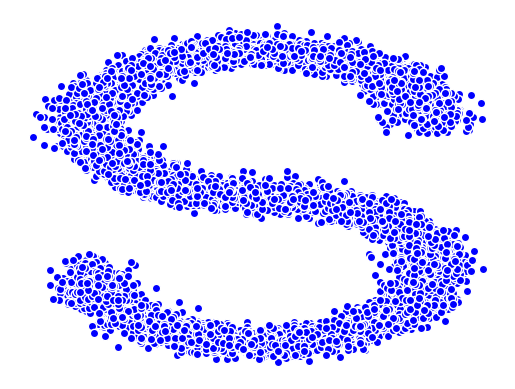

In [12]:
s_curve, _ = make_s_curve(10000, noise=0.1)
s_curve_2d = s_curve[:, [0,2]]/10.0

print('shape of data = {}'.format(s_curve_2d.shape))
plt.scatter(*s_curve_2d.T, color='blue', edgecolor='white')
plt.axis('off')

dataset = torch.Tensor(s_curve_2d).float().to(device)


In [13]:
num_steps = 100
beta_min = 1e-5
beta_max = 5e-3

betas = torch.linspace(-10,10,num_steps).to(device)
betas = torch.sigmoid(betas)*(beta_max-beta_min)+beta_min

alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, 0)
alphas_bar_sqrt = torch.sqrt(alphas_bar)
one_minus_alphas_bar_sqrt = torch.sqrt(1.0-alphas_bar)

# alphas_bar_shifted = torch.cat([torch.tensor([1.0]).to(device), alphas_bar[:-1]],0)

def eval_qxt(x0, t):
    # evaluate the analytical form of forward/diffusion process

    alphas_bar = torch.cumprod(alphas, 0)
    alphas_bar_sqrt = torch.sqrt(alphas_bar)
    one_minus_alphas_bar_sqrt = torch.sqrt(1.0-alphas_bar)

    epsi = torch.randn_like(x0)
    coeff_mean = alphas_bar_sqrt[t]
    coeff_std = one_minus_alphas_bar_sqrt[t]
    xt = x0*coeff_mean + epsi*coeff_std # reparam trick
    return xt


# num_shows = 20
# fig,axs = plt.subplots(2,10,figsize=(28,3))
# plt.rc('text',color='black')
#
# for i in range(num_shows):
#     j = i//10
#     k = i%10
#     q_i = eval_qxt(dataset,torch.tensor([i*num_steps//num_shows]),alphas)#生成t时刻的采样数据
#     axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
#     axs[j,k].set_axis_off()
#     axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*num_steps//num_shows)+'})$')



In [14]:


class MLPDiffusion(nn.Module):
    def __init__(
            self,
            s_dim,
            hidden_dim,
            hidden_layers,
            n_steps,
    ):

        super().__init__()

        self.s_dim = s_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.n_steps = n_steps

        layer_configs = [s_dim] + [hidden_dim]*hidden_layers + [s_dim]

        layers = []
        for i in range(len(layer_configs)-2):
            layers.append(nn.Linear(layer_configs[i], layer_configs[i+1]))
            nn.init.xavier_normal_(layers[-1].weight)
            nn.init.zeros_(layers[-1].bias)
            layers.append(nn.ReLU())
        #

        layers.append(nn.Linear(layer_configs[-2], layer_configs[-1]))
        nn.init.xavier_normal_(layers[-1].weight)
        nn.init.zeros_(layers[-1].bias)

        self.net = nn.ModuleList(layers)
        self.t_embeds = nn.ModuleList([nn.Embedding(n_steps,hidden_dim) for l in range(hidden_layers)])


    def forward(self, x, t):

        for i in range(self.hidden_layers):

            nn_layer = self.net[2*i]
            t_embed_layer = self.t_embeds[i]
            act_layer = self.net[2*i+1]

            x = nn_layer(x)
            x += t_embed_layer(t)
            x = act_layer(x)
        #

        nn_layer = self.net[-1]

        x = nn_layer(x)

        return x

def diffusion_loss_fn(
        model,
        x0,
        n_steps
):
    batch_size = x0.shape[0]

    t = torch.randint(0,n_steps,size=(batch_size//2,))
    t = torch.cat([t,n_steps-1-t],dim=0)
    t = t.unsqueeze(-1)

    coeff_x0 = alphas_bar_sqrt[t]
    coeff_epsi = one_minus_alphas_bar_sqrt[t]

    epsi = torch.randn_like(x0)

    x = x0*coeff_x0 + coeff_epsi*epsi

    pred = model(x,t.squeeze(-1))

    return (epsi - pred).square().mean()

def p_sample_loop(model,shape,n_steps,betas,one_minus_alphas_bar_sqrt):
    """从x[T]恢复x[T-1]、x[T-2]|...x[0]"""
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model,cur_x,i,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def p_sample(model,x,t,betas,one_minus_alphas_bar_sqrt):
    """从x[T]采样t时刻的重构值"""
    t = torch.tensor([t])

    coeff = betas[t] / one_minus_alphas_bar_sqrt[t]

    eps_theta = model(x,t)

    mean = (1/(1-betas[t]).sqrt())*(x-(coeff*eps_theta))

    z = torch.randn_like(x)
    sigma_t = betas[t].sqrt()

    sample = mean + sigma_t * z

    return (sample)

seed = 1234
#
# class EMA():
#     """构建一个参数平滑器"""
#     def __init__(self,mu=0.01):
#         self.mu = mu
#         self.shadow = {}
#
#     def register(self,name,val):
#         self.shadow[name] = val.clone()
#
#     def __call__(self,name,x):
#         assert name in self.shadow
#         new_average = self.mu * x + (1.0-self.mu)*self.shadow[name]
#         self.shadow[name] = new_average.clone()
#         return new_average

print('Training model...')
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
num_epoch = 4000
plt.rc('text',color='blue')

# model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
# optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

idx, batch_x = next(enumerate(dataloader))

# print(idx)
# print(batch_x.shape)

model = MLPDiffusion(
    s_dim=2,
    hidden_dim=128,
    hidden_layers=3,
    n_steps=100,
)

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data.shape)

# model(x,t.squeeze(-1))

diffusion_loss_fn(model,batch_x,alphas,num_steps)



for t in range(num_epoch):
    for idx,batch_x in enumerate(dataloader):
        loss = diffusion_loss_fn(model,batch_x,alphas,num_steps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.)
        optimizer.step()

    if(t%100==0):
        print(loss)
        x_seq = p_sample_loop(model,dataset.shape,num_steps,betas,one_minus_alphas_bar_sqrt)

        fig,axs = plt.subplots(1,10,figsize=(28,3))
        for i in range(1,11):
            cur_x = x_seq[i*10].detach()
            axs[i-1].scatter(cur_x[:,0],cur_x[:,1],color='red',edgecolor='white');
            axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')






Training model...


TypeError: diffusion_loss_fn() takes 3 positional arguments but 4 were given